# Portfolio Optimization with CVaR and SamplingVQE

## Disclaimer
This file contains adaptations from IBM Qiskit CVaR Optimization Tutorial  
https://qiskit-community.github.io/qiskit-optimization/tutorials/08_cvar_optimization.html  
Original copyright (c) IBM 2017, 2024.  
Modified by Colin Farley (2025) for research use at HARP Research.  

## Objective

The goal of this notebook is to recreate, explain, and expand upon the CVaR-based variational quantum optimization techniques introduced by:

- Barkoutsos et al., Quantum 4, 256 (2020)

- IBM Qiskit’s SamplingVQE CVaR Tutorial

We focus on a mean-variance portfolio optimization problem  
Classical benchmarking using NumPyMinimumEigensolver  
We modularize the code to enable experimentation with different solvers, ansätze, and classical optimizers while ensuring reproducibility and educational value.

## 🧮 Problem Formulation: Mean-Variance Portfolio Optimization

We define a binary optimization problem where each variable $ x_i \in \{0, 1\} $ denotes whether to invest in asset $ i $.  
The objective is to **maximize expected return** while **penalizing risk** via a covariance matrix.  
A budget constraint enforces the total number of selected assets.

Formulation:
$
\text{maximize} \quad \mu^T x - q \cdot x^T \Sigma x \quad \text{subject to} \quad \sum x_i = \text{budget}
$


In [ ]:
from experiments.cvar_portfolio.data_utils import load_default_portfolio
from experiments.cvar_portfolio.objective_portfolio import portfolio_to_qp

mu, sigma = load_default_portfolio()
qp = portfolio_to_qp(mu, sigma, 0.5)
print(qp.prettyprint())


Problem name: portfolio_optimization

Maximize
  -0.3656*x_0^2 + 0.6233*x_0*x_1 - 0.4689*x_0*x_2 + 0.5452*x_0*x_3
  + 0.0082*x_0*x_4 + 0.3809*x_0*x_5 - 1.2366*x_1^2 + 0.7538*x_1*x_2
  - 2.4659*x_1*x_3 + 0.0733*x_1*x_4 - 0.8945*x_1*x_5 - 0.57715*x_2^2
  + 1.4095*x_2*x_3 - 0.0007*x_2*x_4 + 0.4301*x_2*x_5 - 1.75335*x_3^2
  - 0.2012*x_3*x_4 - 1.0922*x_3*x_5 - 0.31155*x_4^2 - 0.1509*x_4*x_5
  - 0.4496*x_5^2 + 0.7313*x_0 + 0.9893*x_1 + 0.2725*x_2 + 0.875*x_3 + 0.7667*x_4
  + 0.3622*x_5

Subject to
  Linear constraints (1)
    x_0 + x_1 + x_2 + x_3 + x_4 + x_5 == 3  'c0'

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



## 🧪 Classical Baseline

Before exploring quantum approaches, we solve the constrained problem classically using an exact eigensolver (`NumPyMinimumEigensolver`).  
This provides a **ground truth** for benchmarking quantum algorithms.


In [16]:
from experiments.cvar_portfolio.objective_portfolio import classic_solve

classical_result = classic_solve(qp)
print(classical_result.prettyprint())

objective function value: 1.27835
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS


## 🔄 Constraint Handling and Hamiltonian Mapping

Quantum solvers typically require unconstrained problems in Ising or QUBO form.  
We use `LinearEqualityToPenalty` to transform our constraint into a **penalty term**, then convert to a Pauli-based Hamiltonian via `.to_ising()`.

This is essential for applying algorithms like SamplingVQE and QAOA.


In [17]:
from experiments.cvar_portfolio.objective_portfolio import portfolio_add_penalty

penalty = 12                                    #2 * n
qp = portfolio_add_penalty(qp, penalty)
hamiltonian, offset = qp.to_ising()  
print(hamiltonian) 
print(offset)

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[ 0.455025+0.j, -0.60115 +0.j,  0.378625+0.j, -0.890325+0.j,  0.15975 +0.j,
 -0.37535 +0.j,  5.844175+0.j,  6.117225+0.j,  5.8637  +0.j,  5.99795 +0.j,
  5.904775+0.j,  5.81155 +0.j,  6.616475+0.j,  5.981675+0.j,  6.223625+0.j,
  5.647625+0.j,  6.000175+0.j,  5.892475+0.j,  6.0503  +0.j,  6.27305 +0.j,
  6.037725+0.j])
18.610925000000012


In [ ]:
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

n = 6 # num of binary variables

# set classical optimizer
maxiter = 100
optimizer = COBYLA(maxiter=maxiter)

# set variational ansatz
ansatz = RealAmplitudes(n, reps=1)
m = ansatz.num_parameters

# set sampler
sampler = Sampler()

alphas = [1.0, 0.50, 0.25]  # confidence levels to be evaluated

## 📉 Conditional Value at Risk (CVaR) with SamplingVQE

Instead of optimizing the expected value (which can be diluted by poor-quality samples), we apply **CVaR**, which prioritizes the best-performing measurement outcomes.  

- $ \alpha = 1.0 $ → Full expected value (standard VQE)
- $ \alpha < 1.0 $ → Focus on better tail outcomes

This improves **robustness** and **convergence**, especially on noisy or degenerate landscapes.


In [ ]:
from experiments.cvar_portfolio.objective_portfolio import solve_with_sampling_vqe

results, objectives = solve_with_sampling_vqe(qp, sampler, ansatz, optimizer, offset, alphas)
for alpha in alphas:
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: 1.2783500000000174
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS

alpha = 0.5:
objective function value: 1.2783500000000174
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS

alpha = 0.25:
objective function value: 1.2783500000000174
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS



## 📊 Visualizing Optimization Progress

We plot the CVaR-converged objective values over iterations for different \( \alpha \) levels.  
The red dashed line represents the optimal classical value for comparison.


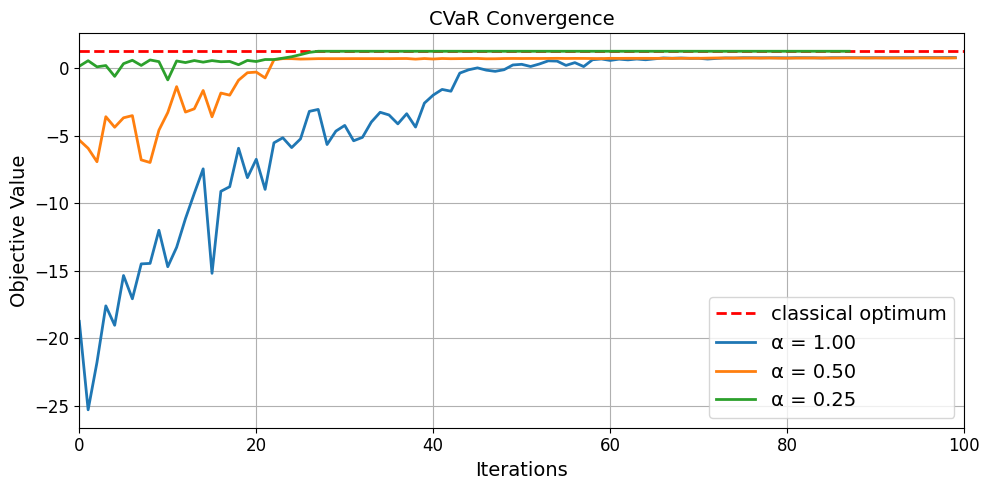

In [24]:
from experiments.cvar_portfolio.plot_cvar_history import plot_cvar_convergence

plot_cvar_convergence(
    objectives,             # dict: {alpha: [objective values per iteration]}
    classical_result.fval,  # float: classical optimum to plot as dashed line
    maxiter,                # int: max number of optimization steps
    "CVaR Convergence"      # str: optional plot title
)

## 📈 Results Interpretation & Impact of CVaR

This plot compares SamplingVQE with different CVaR confidence levels \( \alpha \) against the classical optimum. It shows:

- **Faster convergence** for lower $ \alpha $ values (0.25, 0.50) vs. standard VQE ($ \alpha = 1.0 $).
- **Reduced variance** and smoother optimization when focusing only on the best samples.
- **Reaching the classical optimum**, confirming that CVaR-VQE is competitive with classical methods.

As demonstrated in *Barkoutsos et al., 2020*, this behavior arises because CVaR:
- Filters noisy/bad outcomes that distort feedback to the optimizer
- Provides a smoother landscape with useful gradients even at early iterations
- Encourages high-overlap solutions with the true ground state

This establishes CVaR as a superior objective aggregation method for combinatorial optimization problems on quantum hardware.

**Next notebook: `qaoa_portfolio.ipynb`**